# Intersection over Unity score

In [1]:
import csv
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import numpy as np
import seaborn as sns
import datetime as datetime
from netCDF4 import num2date, date2num
from pyclouds import zooniverse as zn

from PIL import Image
import matplotlib.patches as patches
import matplotlib.image as mpimage

import numba as nb
from collections import defaultdict
import itertools

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
classfile_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-classifications_18_12_16.csv'
subject_in = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [3]:
classification_data = zn.parse_classifications(classfile_in,json_columns=['metadata', 'annotations', 'subject_data']);
prac_dataset = classification_data[np.logical_and(classification_data.workflow_id == 8072,
                                                  classification_data.workflow_version == 24.13) ]; prac_dataset.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
1,128490303,not-logged-in-fc5633eea5ed2784d18f,NaN,fc5633eea5ed2784d18f,8072,Practice,24.13,2018-10-24 18:57:11 UTC,NaN,NaN,"{'source': 'api', 'session': '87cebe5a5f8df494...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977308': {'retired': None, 'fn': '/project...",26977308
2,128623366,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:49:06 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976669': {'retired': None, 'fn': '/project...",26976669
3,128623455,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:49:36 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26976422': {'retired': None, 'fn': '/project...",26976422
4,128623533,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:50:08 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977225': {'retired': None, 'fn': '/project...",26977225
5,128623611,ShCu,1830047.0,ee86d51944114d2d37a9,8072,Practice,24.13,2018-10-25 16:50:39 UTC,NaN,NaN,"{'source': 'api', 'session': '827957f6188eba83...","{'task': 'T0', 'task_label': 'Draw bounding bo...","{'26977129': {'retired': None, 'fn': '/project...",26977129


In [4]:
unique_users = list(prac_dataset['user_name'].unique())

In [5]:
# Restrict comparision only to people who did more than x classifications
unique_users = []
for u,user in prac_dataset.groupby('user_name'):
    if len(user) > 20:
        unique_users.append(u)

In [6]:
image_width =2100
image_height=1400
annos_prac = defaultdict(list)
for i, r in prac_dataset.iterrows():
    if len(r['annotations']['value']) > 0 :
        for a in r['annotations']['value']:
            x = np.max([0., a['x']]); y = np.max([0., a['y']])
            w = np.min([image_width - a['x'], a['width']])
            h = np.min([image_height - a['y'], a['height']])
            annos_prac[r['subject_ids']].append([
                r['user_name'],
                [x, y, w, h],
                a['tool_label']
            ])
    else:   # No annotation
        annos_prac[r['subject_ids']].append([
            r['user_name'],
            [None, None, None, None],
            None
        ])

In [7]:
subjects_prac = list(annos_prac.keys()); len(subjects_prac)

65

In [8]:
annos_prac.keys()

dict_keys([26977308, 26976669, 26976422, 26977225, 26977129, 26976823, 26976672, 26977174, 26976707, 26976578, 26976643, 26976481, 27139777, 27140534, 27140554, 27140608, 27139862, 27140428, 27139658, 27140338, 27140007, 27140443, 27140160, 27140411, 27139807, 27139637, 27139670, 27139724, 27140553, 27140272, 27140248, 27140136, 27140273, 27140760, 27139855, 27140640, 27140686, 27139989, 27139657, 27140139, 27140219, 27140799, 27140298, 27140789, 27139915, 27139921, 27140510, 27140739, 27140444, 27140829, 27140720, 27140749, 27140183, 27139914, 27140649, 27139823, 27140434, 27140513, 27140456, 27139668, 27140002, 27139902, 27140299, 27140038, 27140128])

In [9]:
from pyclouds.iou import iou_multi_class
def get_comp_data(subject_id, user1, user2, annos):
    subj_annos = annos[subject_id]
    users = list(set([a[0] for a in subj_annos]))
    if user1 in users and user2 in users:
        annos1 = [a[1:] for a in subj_annos if a[0] == user1]
        annos2 = [a[1:] for a in subj_annos if a[0] == user2]
        if annos1[0][1] is None and annos2[0][1] is None:
            iou = 1.
        elif annos1[0][1] is None:
            iou = 0.
        elif annos2[0][1] is None:
            iou = 0.
        else:
            iou = iou_multi_class(annos1, annos2, classes=['Sugar', 'Flower', 'Fish', 'Gravel'], img_size=(2100, 1400))
        return iou
    else:
        return None

In [10]:
%load_ext line_profiler

In [11]:
unique_users[0]

'Armin.haghshenas'

In [12]:
agreement  = defaultdict(list)
for s in subjects_prac:
    for u in unique_users:
        agreement[u].append(get_comp_data(s, 'sbony', u, annos_prac))

In [13]:
df = pd.DataFrame(data = {'agreement': [np.mean([a for a in agreement[u] if a is not None]) for u in unique_users]}, index=unique_users)

In [14]:
def time_test():
    agreement  = defaultdict(list)
    for s in subjects_prac:
        agreement[u].append(get_comp_data(s, 'raspstephan', u, annos_prac))

In [15]:
%timeit time_test()

365 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%lprun -f get_comp_data get_comp_data(s, 'sbony', 'raspstephan', annos_prac)

In [46]:
df.sort_values('agreement', axis=0, ascending=False, inplace=True)

In [98]:
%timeit time_test()

355 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
from pyclouds.iou import *

In [93]:
%lprun -f time_test time_test()

In [94]:
%lprun -f iou_one_class_from_annos time_test()

In [95]:
%lprun -f intersect_from_arrs time_test()

In [48]:
df['agreement']

sbony                                 1.000000
raspstephan                           0.340259
cathyhohenegger                       0.337233
bschul                                0.334837
onnoq                                 0.332122
Julia.Windmiller                      0.331742
Octave.T                              0.329299
lpaccini                              0.328244
grandpeix                             0.327727
Raphaela                              0.321383
addisug                               0.317497
seze                                  0.316603
ShCu                                  0.316135
jpmellado                             0.314551
MarcusKlingebiel                      0.310487
christopher.moseley                   0.307964
magio                                 0.307514
tmieslinger                           0.304526
LWMPI                                 0.302423
kemanuel                              0.300532
double_p                              0.297563
anna-lea-albr

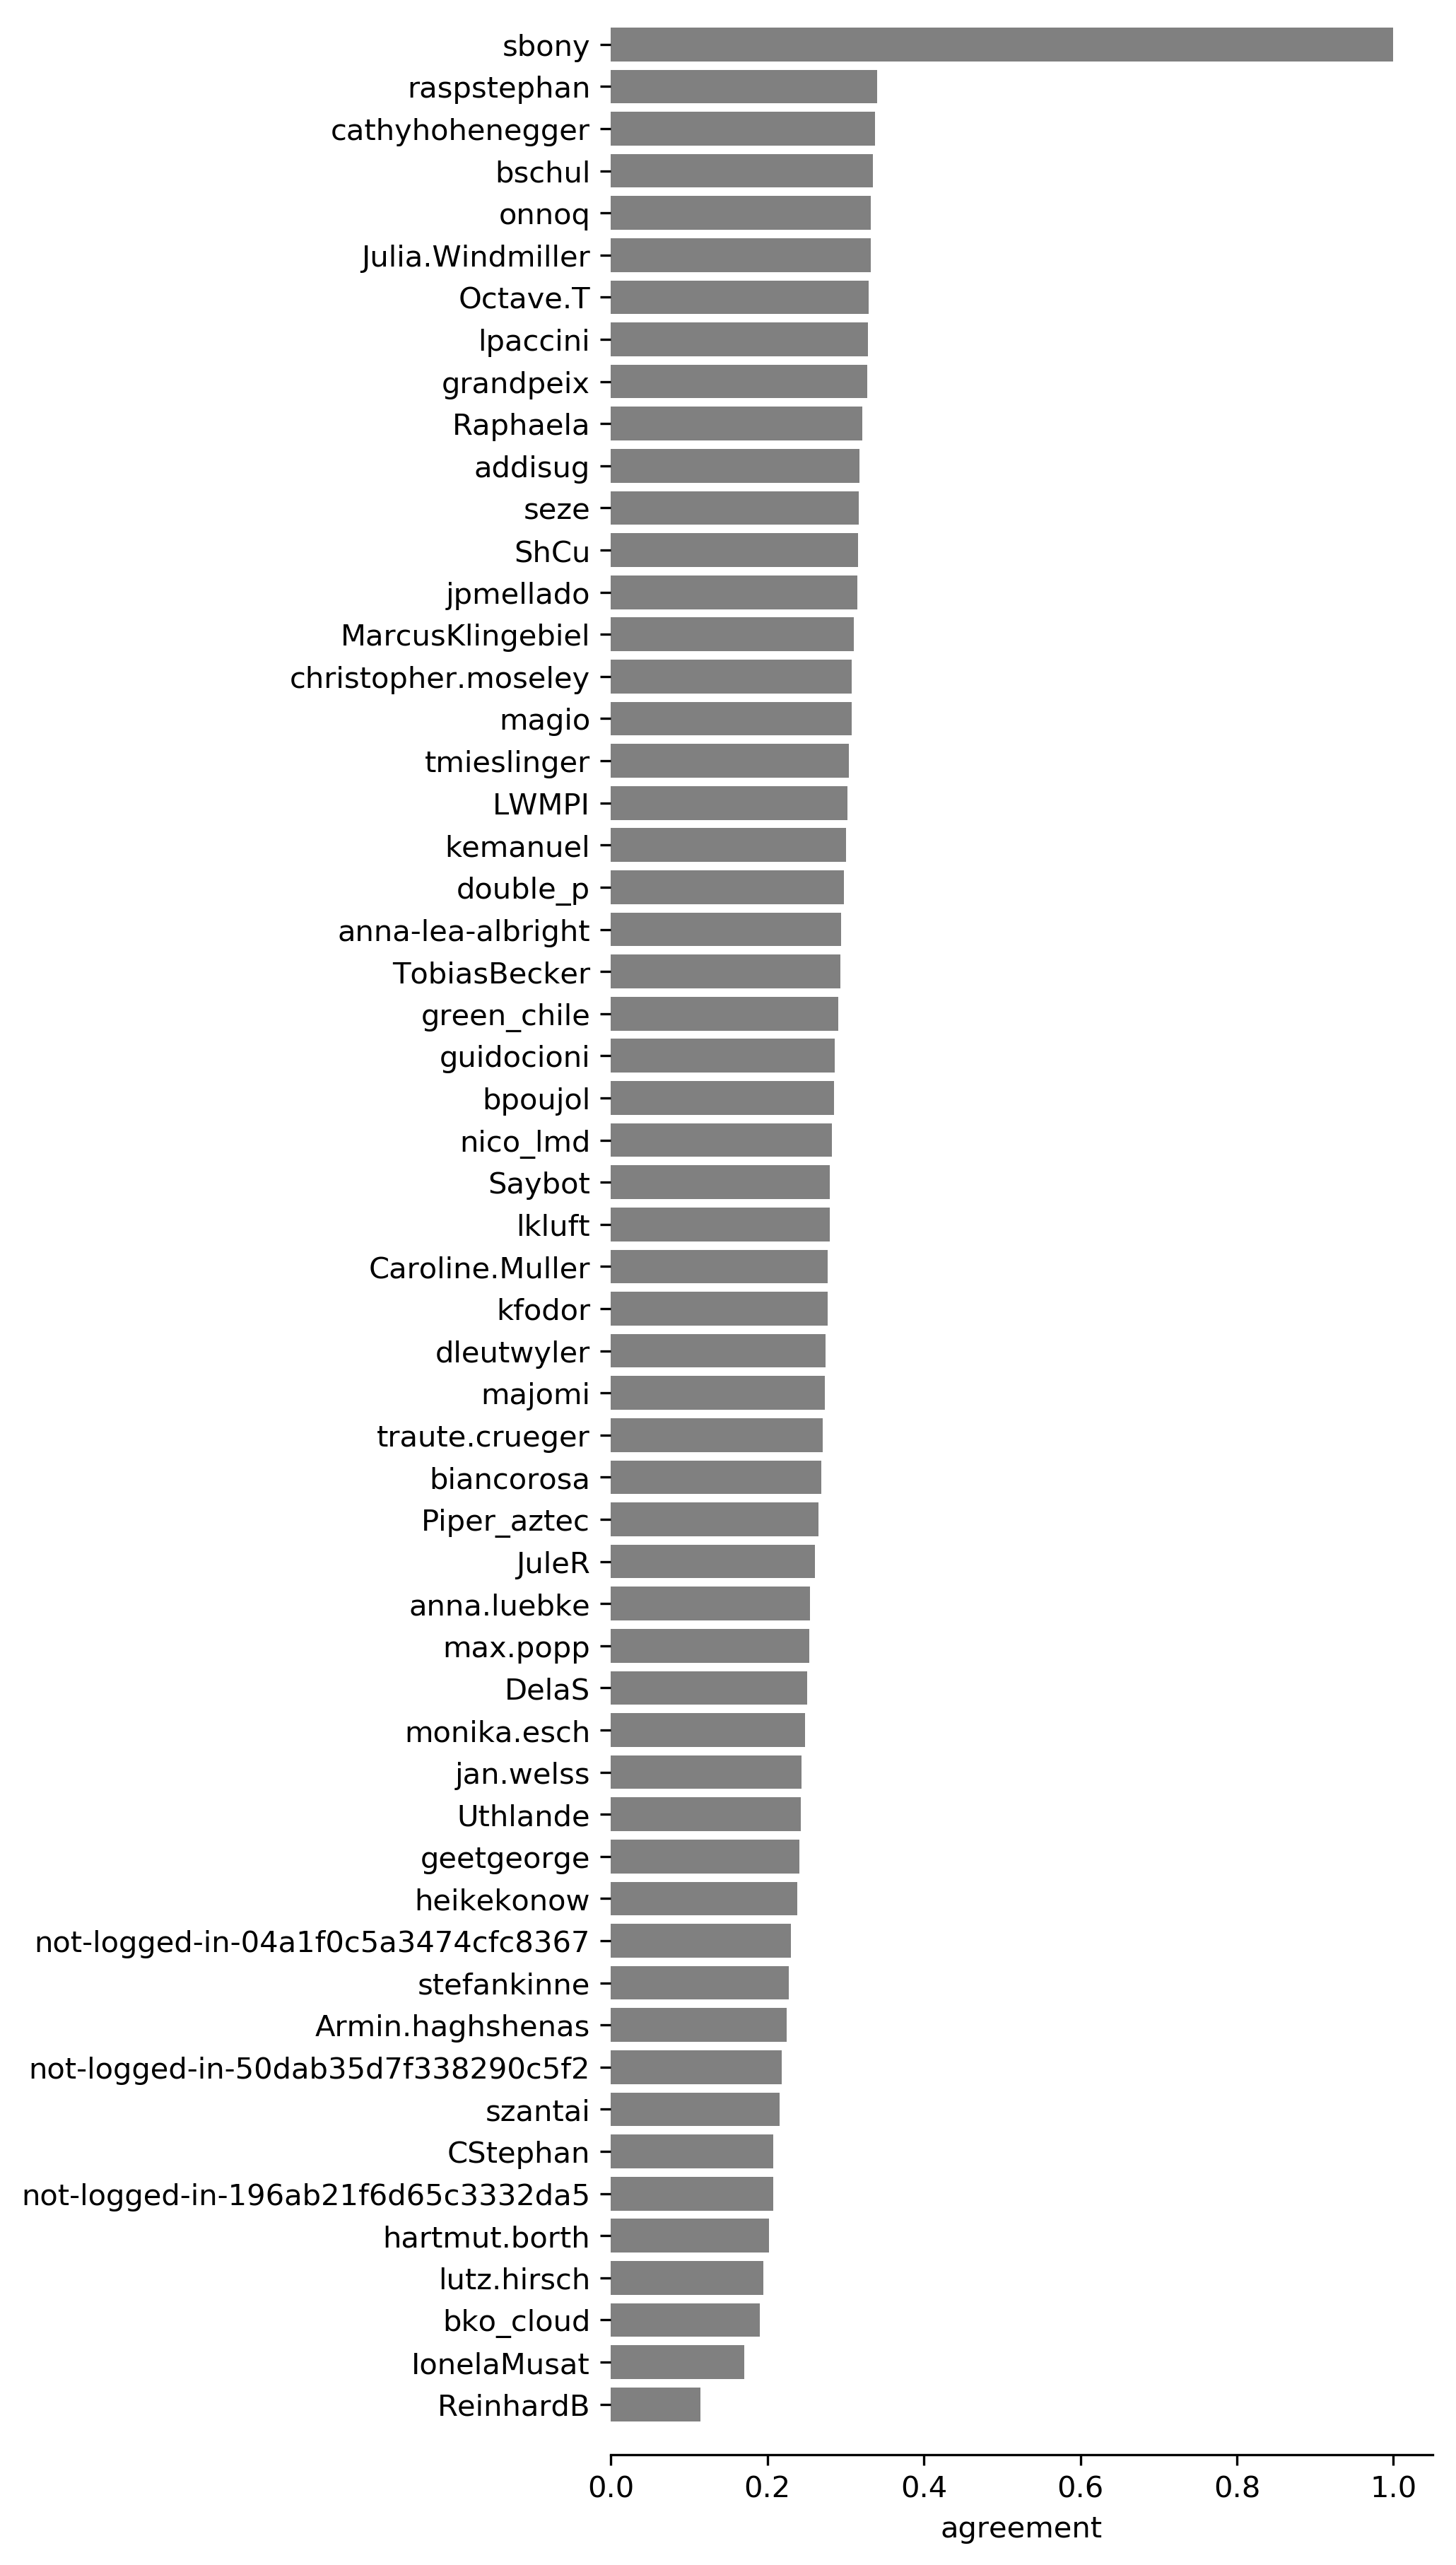

In [47]:
fig = plt.figure(figsize=(5, 15))
sns.barplot(x=df['agreement'], y=df.index,color="grey")
sns.despine(offset=10,left=True)
fig.set_dpi(300)

In [40]:
t.astype(np.int32)

array([1593,  465,  502,  867], dtype=int32)